In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
from LinearMPC.MPCVelControl import MPCVelControl
from PIControl.PIControl import PIControl
import numpy as np
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [3]:
Ts = 0.05
sim_time = 20
H = 5.0
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 100])  # initial state
pos_target = np.array([0, 0, 10.0])

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
pos_controller = PIControl(pos_target)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, pos_control=pos_controller, method="nonlinear"
)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Computing maximum invariant set ...
Maximum invariant set successfully computed after 46 iterations.
Computing maximum invariant set ...
Maximum invariant set successfully computed after 46 iterations.
Computing maximum invariant set ...
Maximum invariant set successfully computed after 1 iterations.
Computing maximum invariant set ...
Maximum invariant set successfully computed after 24 iterations.


/Users/jverbois/Python/epfl/MPC-Course-EPFL/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints violated
State or input constraints v

In [4]:
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 0.8
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
);

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', interval=125, max=399, step=2), Int…

In [5]:
from LinearMPC.utils import ALPHA, BETA
print(np.rad2deg(max(np.abs(x_cl[ALPHA]))))
print(np.rad2deg(max(np.abs(x_cl[BETA]))))

15.22639371085169
15.076255068643212


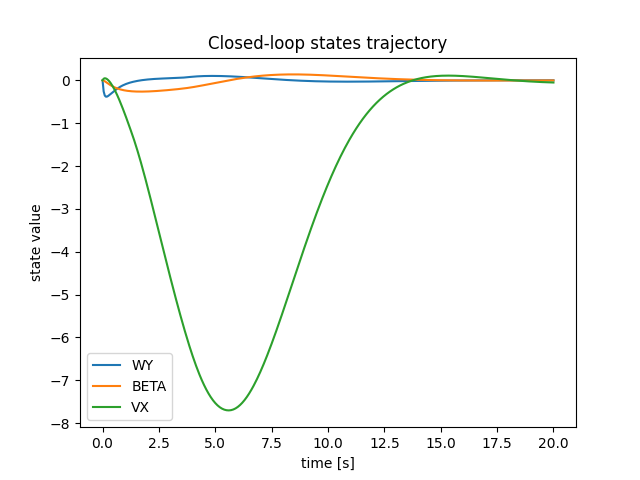

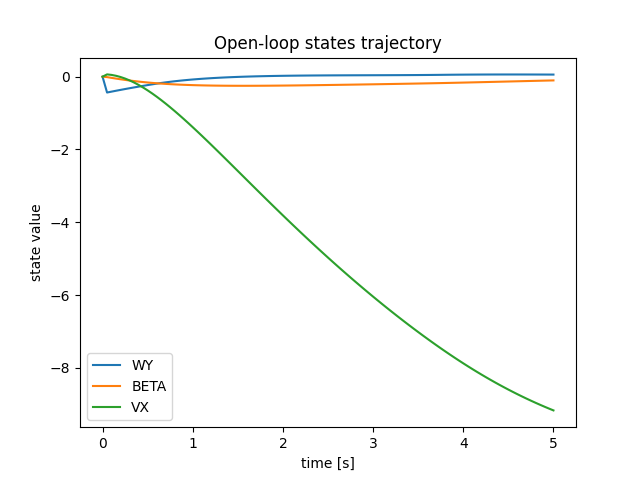

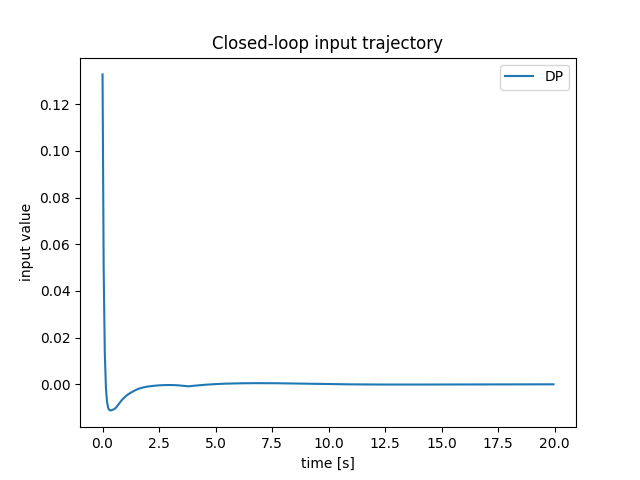

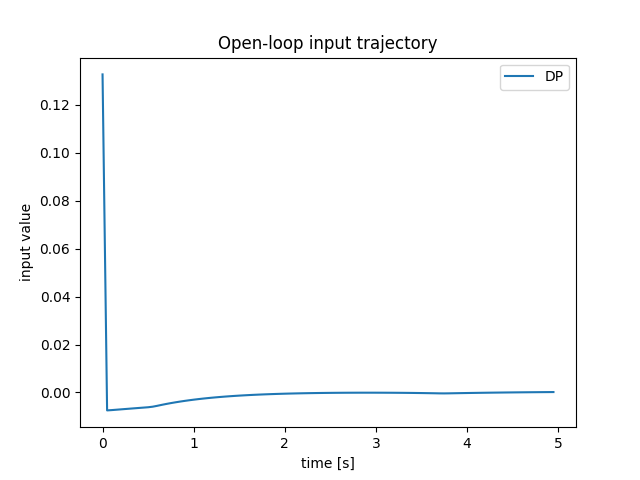

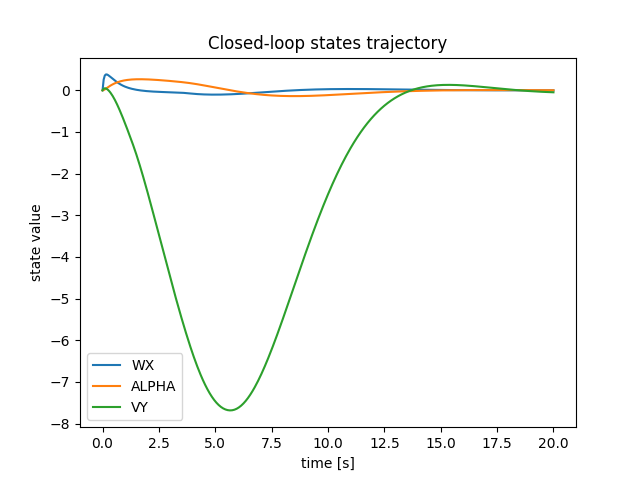

/Users/jverbois/Python/epfl/MPC-Course-EPFL/Model-Predictive-Control-Project/LinearMPC/utils.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  "VZ",


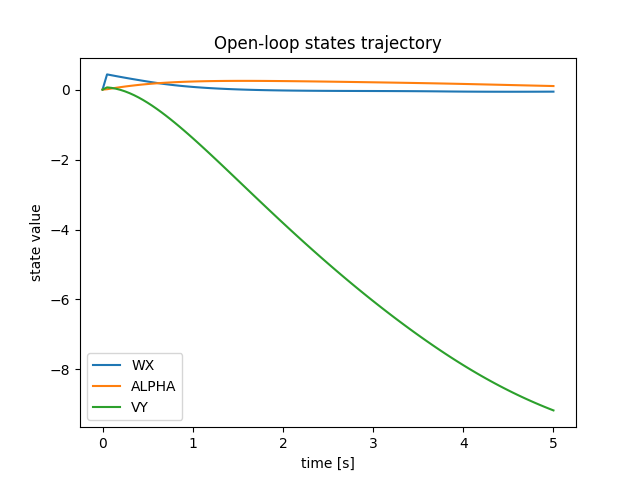

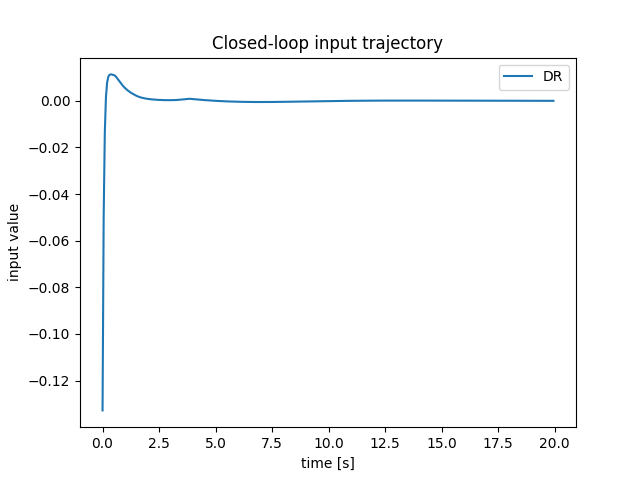

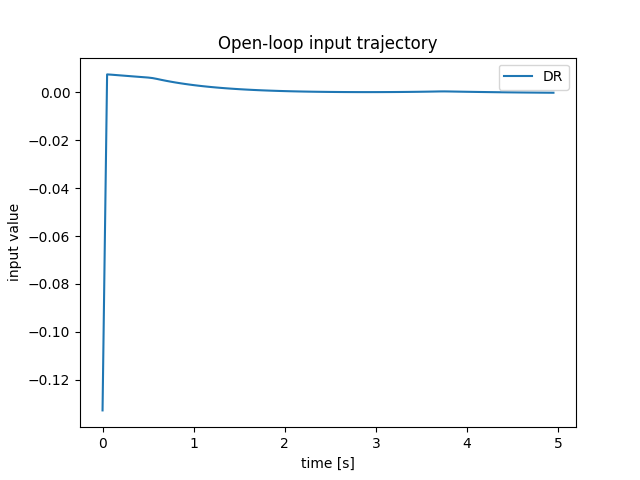

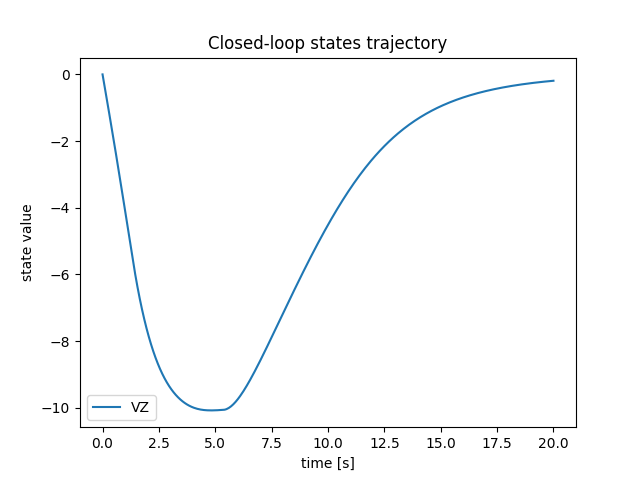

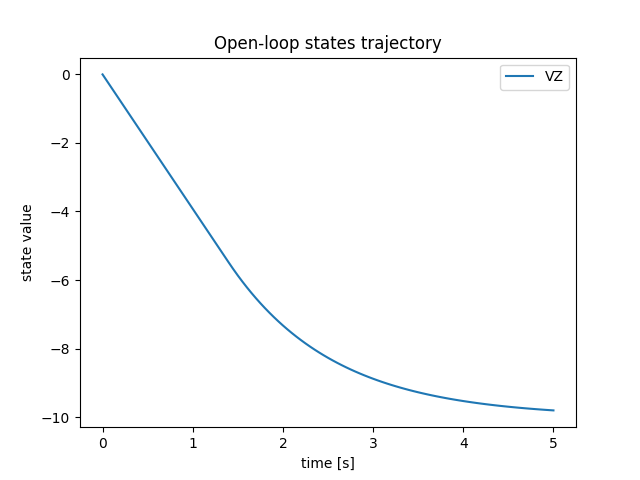

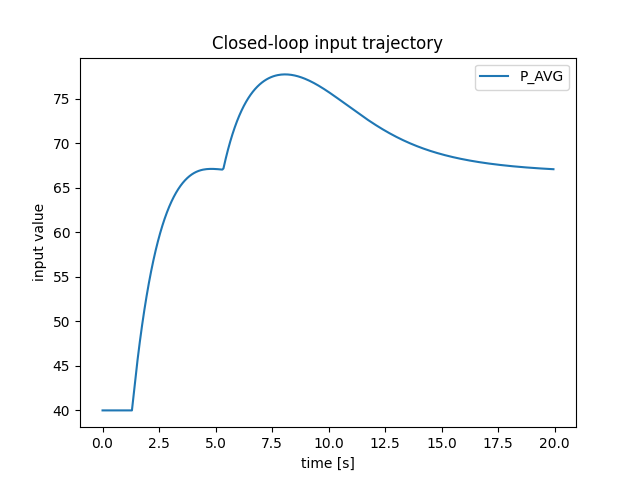

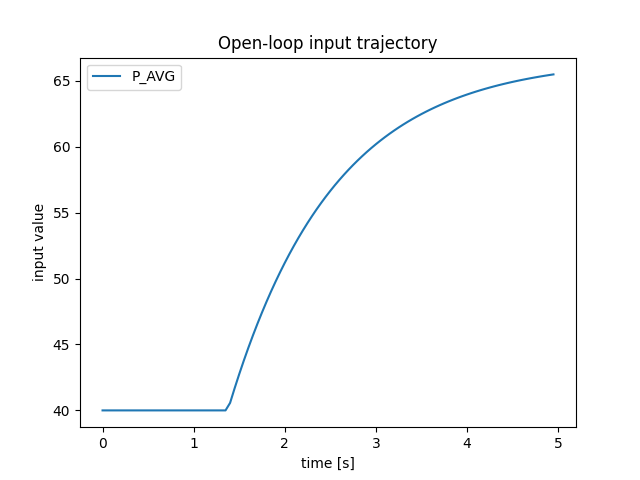

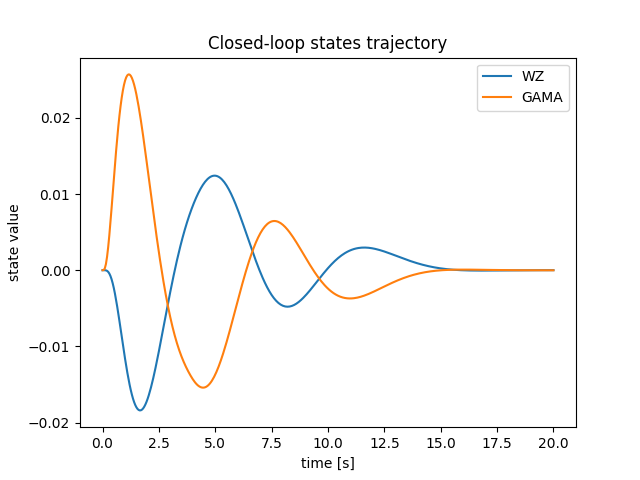

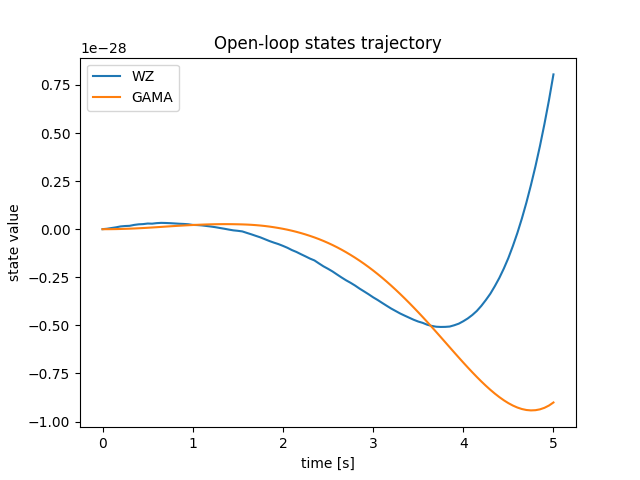

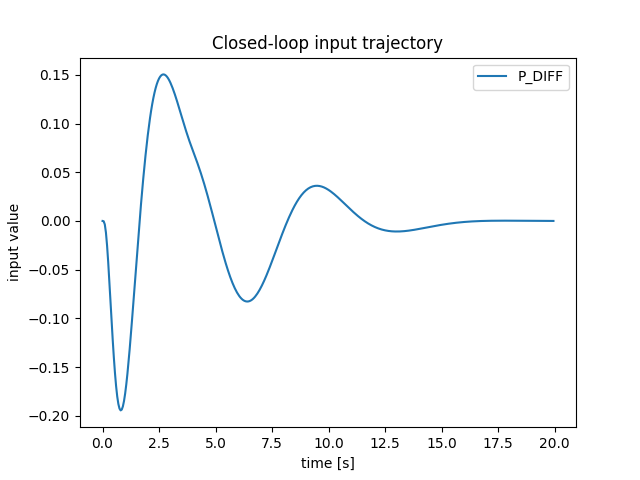

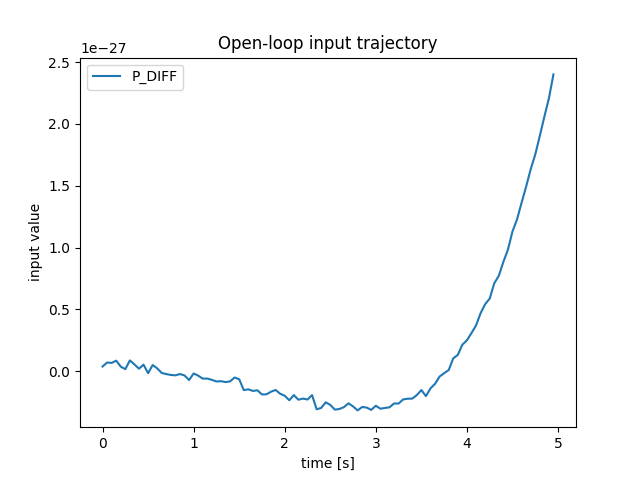

In [14]:
from LinearMPC.utils import plot_trajectory
plot_trajectory(t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, mpc.mpc_x)
plot_trajectory(t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, mpc.mpc_y)
plot_trajectory(t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, mpc.mpc_z)
plot_trajectory(t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, mpc.mpc_roll)
